# PRISM Implementation

## Generate the material using ASE or import into ABTEM

## Define Constants
Probe Size - Property of System (Units in Angstroms)
Detector Sampling - 4pixels for probe diameter (Nyquist)
Wavelength - Property of Electron Energy
Max Probe Angle (alpha) - on order of 10s of milliradians


# Calculate the Simulation


In [100]:
from pathlib import Path
# General Imports

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, colormaps
import scipy as sp

# Imports for Generating and Calculating Potentials
import abtem
import ase
from ase import io as aio

In [101]:
def genfMask(shape,f):
    x = np.arange(shape[0])
    y = np.arange(shape[1])
    
    
    # Create Mask
    return np.logical_and(
        np.mod(x[:,None],f) == 0,
        np.mod(y[None,:],f) == 0,
    )

potential array:  <class 'numpy.ndarray'> float32 (55, 326, 326)


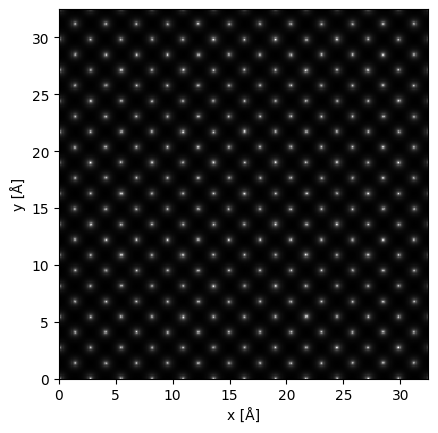

In [102]:
# file_Ta = Path("/Users/antonygeorgiadis/Desktop/Stanford Research/OphusLabCoding/Ta_sim_model.xyz")
# assert file_Ta.exists()
# material = "a_Ta"
# species = "Ta"



# atoms = aio.read(file_Ta, format='prismatic')

# # the full material is a little bigger than you probably want, so we filter it down
# # note that this removes pbcs in x and y
# dimx, dimy, dimz = 50, 50, 50 # A
# pbcs = [0,0,0]
# filt = (atoms.positions[:,0] <= dimx) & (atoms.positions[:,1] < dimy) & (atoms.positions[:,2] < dimz)
# bads = np.where(~filt)
# del atoms[bads]

# ncell = np.copy(atoms.cell.array)
# ncell[0,0] = min(dimx, atoms.positions[:,0].max())
# ncell[1,1] = min(dimy, atoms.positions[:,1].max())
# ncell[2,2] = dimz
# atoms.set_cell(ncell)
# atoms.set_pbc(pbcs)

# print(f"total atoms: {atoms.positions.shape[0]}")
# print(f"cell:\n{atoms.cell}")

material = species = "Si"
tiling = [6,6,5] # Determines how many multiples of unit cell to extend the material in each direction
atoms = ase.build.bulk(material, cubic=True) * tiling

sampling = 0.1 # A, realspace potential sampling xy, Angstroms
slice_thickness = 0.5 # A sampling z, An
device='cpu' # gpu
N_frozen_phonons = 8

# simulating with a perfect crystal can lead to funkiness, more phonons is better but slower
frozen_phonons = abtem.FrozenPhonons(
    atoms,
    N_frozen_phonons,
    sigmas=0.03,
    seed=42,
)

potential = abtem.Potential(
    frozen_phonons,
    sampling=sampling,
    slice_thickness=slice_thickness,
    parametrization='kirkland',
    projection='infinite', # faster, less accurate the finite
    device=device,
)
potential.project().show()

# Get the potential array for doing a practice of potential slicing
pot = potential.build()
pot_array = pot.array
print("potential array: ", type(pot_array), pot_array.dtype, pot_array.shape)

In [103]:
# Make the probe array match the original array
pixel_size = 0.1 # All units are in angstroms for computational simulations
pot_array = pot_array[:,:256,:256]
pot_shape = np.shape(pot_array)
im_shape = (pot_shape[1],pot_shape[2]) # Pixel array size
probe_mrads = 20 # Max alpha
wavl = 0.02 # Wavelength (angstroms)
f = 4



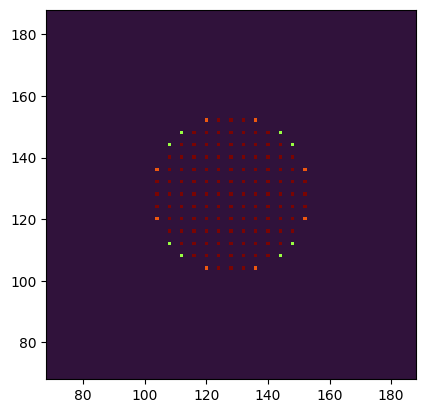

In [104]:
# Generate the plane wave array
# Coordinates
kx = np.fft.fftfreq(im_shape[0], pixel_size) # Creates a frequency array scaled to the inverse of the real value passed
ky = np.fft.fftfreq(im_shape[1], pixel_size) # Creates a frequency array scaled to the inverse of the real value passed
kr2 = kx[:,None]**2+ky[None,:]**2
kr = kr2**0.5

# Probe
k_max = probe_mrads/1000/wavl
# Psi0 = kr < k_max
Psi0 = np.clip((k_max-kr)/(kx[1]-kx[0])+0.5,0,1)

# Generate Brightfield and Annular DarkField Masks
bf_cutoff = 10/1000/wavl
adf_cutoff = 50/1000/wavl
BF_mask = np.clip((bf_cutoff-kr)/(kx[1]-kx[0])+0.5,0,1)
ADF_mask = np.clip((adf_cutoff-kr)/(kx[1]-kx[0])+0.5,0,1) * bf_cutoff


psi0 = np.fft.ifft2(Psi0)
# defocus = 
# print(k_max)

mask = genfMask(im_shape,f)

Psi0downsampled = Psi0*mask
psi0downsampled = np.fft.ifft2(Psi0)

# Displayed the Downsampled pupil
fig,ax = plt.subplots()
# ax.plot(np.fft.fftshift(kx))
ax.imshow(np.fft.fftshift(np.abs(Psi0downsampled)),cmap="turbo")
ax.set_xlim((im_shape[1]/2-60,im_shape[1]/2+60))
ax.set_ylim((im_shape[1]/2-60,im_shape[1]/2+60))

# Generate plane waves
def getSpatialFrequencyArrayData(sampledPupil):
    x,y = np.where(sampledPupil>0)
    h,w = np.shape(sampledPupil)
    planeWaveStack = np.zeros((len(x),h,w),np.complex128)
    values = np.zeros(len(x))
    
    array = np.zeros((h,w))
    for i,coords in enumerate(zip(x,y)):
        xCord, yCord = coords
        array *= 0
        array[xCord,yCord] = 1
        values[i] = sampledPupil[xCord,yCord]
        planeWaveStack[i,:,:] = np.fft.ifft2(array) # Careful to ifft because going from frequency to real space
        
    return planeWaveStack, np.column_stack((x,y)), values

planeWaveStack, coords, values = getSpatialFrequencyArrayData(Psi0downsampled)

In [105]:
# Display the pupil mask


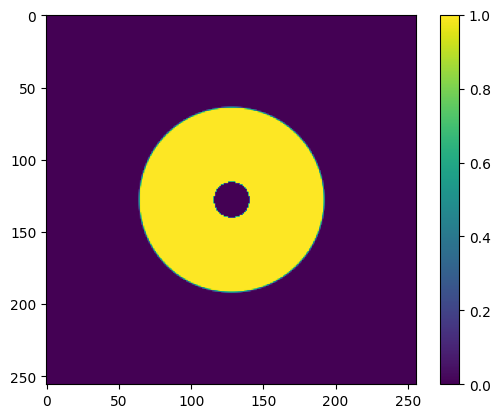

In [106]:
bf_cutoff = 10/1000/wavl
adf_cutoff = 50/1000/wavl
BF_mask = np.clip((bf_cutoff-kr)/(kx[1]-kx[0])+0.5,0,1)
ADF_mask = np.clip((adf_cutoff-kr)/(kx[1]-kx[0])+0.5,0,1) + BF_mask

ADF_mask[ADF_mask>=2] = 0 
ADF_mask[ADF_mask>=1] = 1 
plt.imshow(np.fft.fftshift(ADF_mask))
plt.colorbar()

In [108]:
# Propogate each plane wave through the block

# Create an array for storing the final plane waves
propogatedPlaneWaves = np.zeros(np.shape(planeWaveStack),dtype=np.complex128)
numPotentialPlanes = len(pot_array)
layerSeperation = 0.5 # Angstroms
sigma = 0.0006547


# This propogates assuming a particular layer speration and sigma value
for i, planeWave in enumerate(planeWaveStack):
    for j, potentialPlane in enumerate(pot_array):
        # Interact with potential layer
        postPotential = planeWave*np.exp(-1j*potentialPlane*sigma)
        # Propogate using Fresnel Diffraction
        if j == numPotentialPlanes-1:
            # Perform a final fft for the diffraction step
            # planeWave = np.fft.fft2(postPotential)
            pass
        else:
            # Propogate the interplane distance
            planeWave = np.fft.ifft2(np.fft.fft2(postPotential)*np.exp(1j*np.pi*wavl*layerSeperation*np.abs(kr2)))
            
    propogatedPlaneWaves[i] = planeWave
            
        
        

    

In [128]:
# Calculate alpha
k_x = kx[:,None]
k_y = ky[None,:]

# General Displacement
dr = (3.5,5) # Angstroms

#Convert to pixel displacement
x = int(dr[0]/pixel_size)
y = int(dr[1]/pixel_size)

# Calculate
probe_shift = np.exp(-2j*np.pi*(k_x*dr[0]+k_y*dr[1]))

# Calculate Probe Shift based on spatial frequencies
print(np.shape(coords))
alpha = probe_shift[coords[:,0],coords[:,1]]


# Apply Alpha in frequency space
alpha_prop_freq = alpha[:,None,None] * np.fft.fft2(propogatedPlaneWaves)
alpha_prop = np.fft.ifft2(alpha_prop_freq) # Put back in real space
real_probe_sum = np.sum(alpha_prop,0) # Sum over the real space
sub_mask = np.zeros(im_shape)
sub_mask[int(x-(im_shape[0]/f)/2):int(x+(im_shape[0]/f)/2),int(y-(im_shape[1]/f)/2):int(y+(im_shape[1]/f)/2)] = 1
sub_sampled_probe = sub_mask*real_probe_sum

# print(im_shape[0]/f)
# print(x-(im_shape[0]/f/2))
# print(int(x-(im_shape[0]/f)/2))
# print(int(x+(im_shape[0]/f)/2))
# Sample over the smaller region
measurement = np.abs(np.fft.fft2(sub_sampled_probe))**2


(137, 2)


/var/folders/4x/mw9x1c5d5910xmv3lsr543ch0000gn/T/ipykernel_75150/3475929496.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


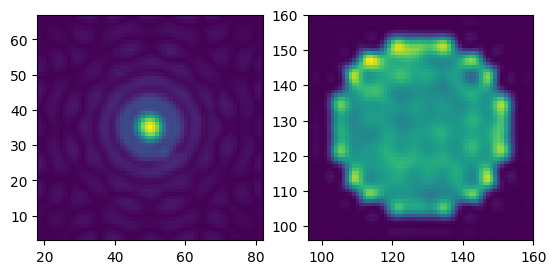

In [129]:
# Test that shifting corresponds to shift of pupils
fig, ax = plt.subplots(1,2)
ax[0].imshow(np.abs(sub_sampled_probe),cmap="viridis")
ax[0].set_ylim(int(x-(im_shape[0]/f)/2),int(x+(im_shape[0]/f)/2))
ax[0].set_xlim(int(y-(im_shape[1]/f)/2),int(y+(im_shape[1]/f)/2))
ax[1].imshow(np.fft.fftshift(measurement), cmap = "viridis")
center = np.array(im_shape)/2
ax[1].set_xlim(int(center[0]-(im_shape[0]/f)/2),int(center[0]+(im_shape[0]/f)/2))
ax[1].set_ylim(int(center[1]-(im_shape[1]/f)/2),int(center[1]+(im_shape[1]/f)/2))
fig.show()

/var/folders/4x/mw9x1c5d5910xmv3lsr543ch0000gn/T/ipykernel_75150/1916028462.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


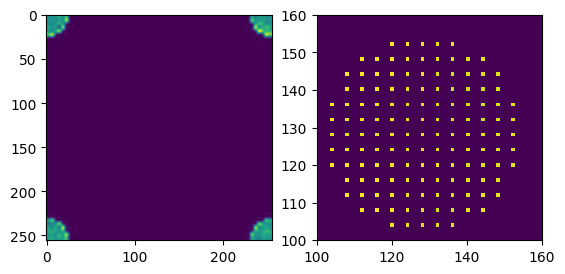

In [130]:
# Test that shifting corresponds to shift of pupils
fig, ax = plt.subplots(1,2)
ax[0].imshow(measurement)
# ax[0].set_ylim(70,110)
# ax[0].set_xlim(100,150)
ax[1].imshow(np.fft.fftshift(np.abs(np.fft.fft2(real_probe_sum))**2))
ax[1].set_ylim(100,160)
ax[1].set_xlim(100,160)
fig.show()


(192, 192)


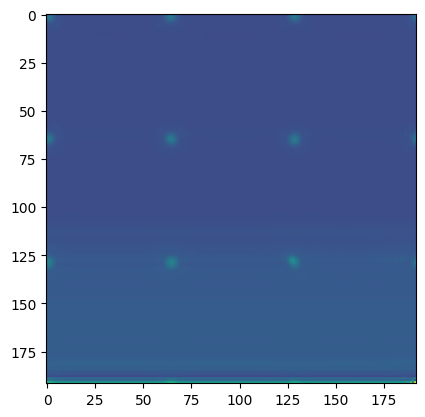

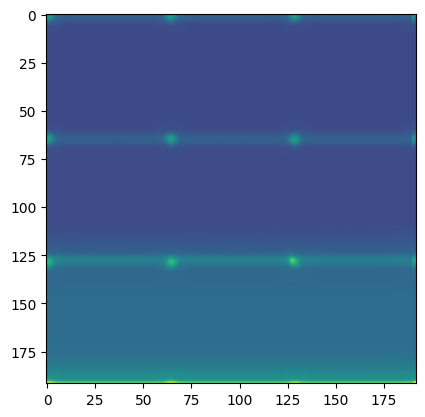

In [ ]:
# Create an Image by taking a small subset of the objects final patterns

# Initialize Dark Field/Brightfield measurement arrays
bf_measurement = np.zeros((im_shape[0]-int(im_shape[0]/f),im_shape[1]-int(im_shape[1]/f)))
adf_measurement = bf_measurement.copy()
print(np.shape(bf_measurement))
# Apply the weighted edges from the tapered edges of pupil
Psi0Array = propogatedPlaneWaves*values[:,None,None]

# No pupil weightings at first so just add them all up
finalArray = np.sum(Psi0Array,0)


# Blank for ffting
blankArray = np.zeros(im_shape,dtype=np.complex128)



for i in range(im_shape[0]-int(im_shape[0]/f)):
    for j in range(im_shape[1]-int(im_shape[1]/f)):

        blankArray[i:int(i+im_shape[0]/f),j:int(j+im_shape[1]/f)] = finalArray[i:int(i+im_shape[0]/f),j:int(j+im_shape[1]/f)]
        farfield = np.abs(np.fft.fftshift(np.fft.fft2(blankArray)))**2
        bf_measurement[i,j] = np.sum(farfield*BF_mask)
        adf_measurement[i,j] = np.sum(farfield*ADF_mask)
        blank = 0
        

plt.imshow(bf_measurement)
plt.show()

plt.imshow(adf_measurement)
plt.show()

